# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time

# wait_to_make = "trained_list/mpnet-base-trans.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    


In [2]:
_mixout = 0.9
EXP_NAME = f"microsoft-deberta-large-v3-large-kfskyAttention"


In [3]:
# !nvidia-smi
! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "microsoft/deberta-v3-large"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=6
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=6
    mixout = True
    mixout_prob = _mixout
    pass_fold = [None]
    
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [8]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [9]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig,AutoModelForTokenClassification,AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [10]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    if os.path.exists(filename):
        os.remove(filename)
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [11]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [12]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [13]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

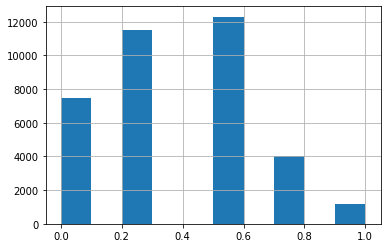

In [14]:
train['score'].hist()

In [15]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [16]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [17]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [18]:
# !pip install --no-cache-dir sentencepiece

In [19]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [20]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [21]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset


torch.__version__: 1.9.0+cu111


In [22]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [23]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        # self.attention = nn.Sequential(
        #     nn.Linear(self.config.hidden_size, 512),
        #     nn.Tanh(),
        #     nn.Linear(512, 1),
        #     nn.Softmax(dim=1)
        # )
        self.attention = nn.Sequential( 
            nn.Linear(self.config.hidden_size, self.config.hidden_size), 
            nn.LayerNorm(self.config.hidden_size), 
            nn.GELU(), 
            nn.Linear(self.config.hidden_size, 1), 
            nn.Softmax(dim=1) 
        )
        self._init_weights(self.attention)
        
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [24]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
        
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
        
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output

# Helpler functions

In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if "train" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)

        model.to(device)                
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(torch.squeeze(y_preds, 1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(torch.squeeze(y_preds,1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [26]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):

    # ====================================================
    # model & optimizer
    # ====================================================
    if "transformer" in EXP_NAME:
        model = CustomModelTransformer(CFG, config_path=None, pretrained=True)
    else:
        model = CustomModel(CFG, config_path=None, pretrained=True)
    if "all" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)
    model.to(device)
                
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    # criterion = nn.MSELoss()
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{folcd}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [27]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.pass_fold:continue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/4559] Elapsed 0m 0s (remain 60m 7s) Loss: 0.7171(0.7171) Grad: inf  LR: 0.00002000  
Epoch: [1][100/4559] Elapsed 0m 40s (remain 29m 55s) Loss: 0.7511(0.6657) Grad: 73716.6875  LR: 0.00002000  
Epoch: [1][200/4559] Elapsed 1m 22s (remain 29m 41s) Loss: 0.5265(0.6420) Grad: 62418.7930  LR: 0.00002000  
Epoch: [1][300/4559] Elapsed 2m 2s (remain 28m 59s) Loss: 0.5649(0.6281) Grad: 49108.2930  LR: 0.00001999  
Epoch: [1][400/4559] Elapsed 2m 43s (remain 28m 17s) Loss: 0.5082(0.6195) Grad: 65312.6758  LR: 0.00001999  
Epoch: [1][500/4559] Elapsed 3m 24s (remain 27m 36s) Loss: 0.7555(0.6107) Grad: 89817.6250  LR: 0.00001998  
Epoch: [1][600/4559] Elapsed 4m 6s (remain 27m 0s) Loss: 0.5025(0.6073) Grad: 58466.1953  LR: 0.00001998  
Epoch: [1][700/4559] Elapsed 4m 48s (remain 26m 25s) Loss: 0.7635(0.6012) Grad: 83488.0000  LR: 0.00001997  
Epoch: [1][800/4559] Elapsed 5m 29s (remain 25m 46s) Loss: 0.3529(0.5949) Grad: 38105.2695  LR: 0.00001996  
Epoch: [1][900/4559] Elapsed 6m 1

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 7m 37s) Loss: 0.3392(0.3392) 
EVAL: [100/1520] Elapsed 0m 11s (remain 2m 34s) Loss: 0.5913(0.5469) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 21s) Loss: 0.4204(0.5513) 
EVAL: [300/1520] Elapsed 0m 32s (remain 2m 10s) Loss: 0.4855(0.5462) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 59s) Loss: 0.7486(0.5418) 
EVAL: [500/1520] Elapsed 0m 53s (remain 1m 48s) Loss: 0.5035(0.5427) 
EVAL: [600/1520] Elapsed 1m 4s (remain 1m 37s) Loss: 0.6331(0.5458) 
EVAL: [700/1520] Elapsed 1m 14s (remain 1m 27s) Loss: 0.5117(0.5447) 
EVAL: [800/1520] Elapsed 1m 25s (remain 1m 16s) Loss: 0.5554(0.5424) 
EVAL: [900/1520] Elapsed 1m 36s (remain 1m 6s) Loss: 0.6187(0.5433) 
EVAL: [1000/1520] Elapsed 1m 46s (remain 0m 55s) Loss: 0.5026(0.5427) 
EVAL: [1100/1520] Elapsed 1m 57s (remain 0m 44s) Loss: 0.5184(0.5433) 
EVAL: [1200/1520] Elapsed 2m 7s (remain 0m 33s) Loss: 0.3639(0.5419) 
EVAL: [1300/1520] Elapsed 2m 18s (remain 0m 23s) Loss: 0.7408(0.5424) 
EVAL: [1400/1520] Elap

Epoch 1 - avg_train_loss: 0.5642  avg_val_loss: 0.5427  time: 2022s
Epoch 1 - Score: 0.8344
Epoch 1 - Save Best Score: 0.8344 Model


EVAL: [1519/1520] Elapsed 2m 41s (remain 0m 0s) Loss: 0.6435(0.5427) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/4559] Elapsed 0m 0s (remain 60m 51s) Loss: 0.4820(0.4820) Grad: 236574.8594  LR: 0.00001866  
Epoch: [2][100/4559] Elapsed 0m 41s (remain 30m 16s) Loss: 0.6223(0.5426) Grad: 426029.0312  LR: 0.00001860  
Epoch: [2][200/4559] Elapsed 1m 20s (remain 29m 13s) Loss: 0.5385(0.5319) Grad: 156775.7188  LR: 0.00001854  
Epoch: [2][300/4559] Elapsed 2m 0s (remain 28m 25s) Loss: 0.5589(0.5249) Grad: 21525.9219  LR: 0.00001848  
Epoch: [2][400/4559] Elapsed 2m 40s (remain 27m 41s) Loss: 0.4324(0.5198) Grad: 42461.8945  LR: 0.00001842  
Epoch: [2][500/4559] Elapsed 3m 19s (remain 26m 58s) Loss: 0.6300(0.5222) Grad: 9434.1279  LR: 0.00001836  
Epoch: [2][600/4559] Elapsed 3m 59s (remain 26m 17s) Loss: 0.4969(0.5219) Grad: 15646.0908  LR: 0.00001829  
Epoch: [2][700/4559] Elapsed 4m 39s (remain 25m 36s) Loss: 0.6801(0.5240) Grad: 13671.8828  LR: 0.00001823  
Epoch: [2][800/4559] Elapsed 5m 18s (remain 24m 56s) Loss: 0.5788(0.5227) Grad: 164031.0312  LR: 0.00001816  
Epoch: [2][900/4559]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 7m 52s) Loss: 0.3504(0.3504) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 32s) Loss: 0.6054(0.5705) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 20s) Loss: 0.4196(0.5770) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 9s) Loss: 0.6091(0.5718) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 58s) Loss: 1.1529(0.5680) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.5456(0.5653) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 37s) Loss: 0.5567(0.5683) 
EVAL: [700/1520] Elapsed 1m 14s (remain 1m 26s) Loss: 0.4947(0.5657) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5744(0.5626) 
EVAL: [900/1520] Elapsed 1m 35s (remain 1m 5s) Loss: 0.6470(0.5637) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.5447(0.5647) 
EVAL: [1100/1520] Elapsed 1m 56s (remain 0m 44s) Loss: 0.5334(0.5654) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.3501(0.5646) 
EVAL: [1300/1520] Elapsed 2m 17s (remain 0m 23s) Loss: 0.8897(0.5655) 
EVAL: [1400/1520] Elaps

Epoch 2 - avg_train_loss: 0.5255  avg_val_loss: 0.5644  time: 1983s
Epoch 2 - Score: 0.8320


EVAL: [1519/1520] Elapsed 2m 40s (remain 0m 0s) Loss: 0.6326(0.5644) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/4559] Elapsed 0m 0s (remain 37m 41s) Loss: 0.6248(0.6248) Grad: 49626.9531  LR: 0.00001500  
Epoch: [3][100/4559] Elapsed 0m 40s (remain 29m 33s) Loss: 0.6000(0.5092) Grad: 51739.7812  LR: 0.00001490  
Epoch: [3][200/4559] Elapsed 1m 19s (remain 28m 51s) Loss: 0.5694(0.5175) Grad: 52933.7930  LR: 0.00001480  
Epoch: [3][300/4559] Elapsed 1m 59s (remain 28m 11s) Loss: 0.6163(0.5142) Grad: 93799.5469  LR: 0.00001470  
Epoch: [3][400/4559] Elapsed 2m 39s (remain 27m 31s) Loss: 0.4168(0.5087) Grad: 1187537.2500  LR: 0.00001460  
Epoch: [3][500/4559] Elapsed 3m 18s (remain 26m 51s) Loss: 0.3947(0.5041) Grad: 188011.5156  LR: 0.00001449  
Epoch: [3][600/4559] Elapsed 3m 58s (remain 26m 11s) Loss: 0.6567(0.5067) Grad: 74059.7969  LR: 0.00001439  
Epoch: [3][700/4559] Elapsed 4m 38s (remain 25m 31s) Loss: 0.4988(0.5076) Grad: 79226.9219  LR: 0.00001429  
Epoch: [3][800/4559] Elapsed 5m 17s (remain 24m 51s) Loss: 0.8658(0.5090) Grad: 158865.5000  LR: 0.00001418  
Epoch: [3][900/455

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 7m 36s) Loss: 0.3285(0.3285) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6132(0.5599) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.4206(0.5620) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.4721(0.5552) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.7455(0.5465) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.4929(0.5472) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.5891(0.5526) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.4920(0.5500) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5643(0.5494) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.6711(0.5506) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.4891(0.5517) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 44s) Loss: 0.5165(0.5515) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.3543(0.5510) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 23s) Loss: 0.6584(0.5505) 
EVAL: [1400/1520] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 3 - avg_train_loss: 0.5105  avg_val_loss: 0.5496  time: 1968s
Epoch 3 - Score: 0.8514
Epoch 3 - Save Best Score: 0.8514 Model


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6368(0.5496) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/4559] Elapsed 0m 0s (remain 51m 1s) Loss: 0.4447(0.4447) Grad: 21190.8379  LR: 0.00001000  
Epoch: [4][100/4559] Elapsed 0m 40s (remain 29m 34s) Loss: 0.6333(0.5010) Grad: 112299.5234  LR: 0.00000988  
Epoch: [4][200/4559] Elapsed 1m 19s (remain 28m 49s) Loss: 0.3940(0.5082) Grad: 61593.4297  LR: 0.00000977  
Epoch: [4][300/4559] Elapsed 1m 59s (remain 28m 8s) Loss: 0.3666(0.5008) Grad: 193576.5938  LR: 0.00000965  
Epoch: [4][400/4559] Elapsed 2m 38s (remain 27m 28s) Loss: 0.5346(0.5017) Grad: 7831.9375  LR: 0.00000954  
Epoch: [4][500/4559] Elapsed 3m 18s (remain 26m 47s) Loss: 0.4425(0.5008) Grad: 42228.5508  LR: 0.00000942  
Epoch: [4][600/4559] Elapsed 3m 58s (remain 26m 8s) Loss: 0.4894(0.4969) Grad: 362334.2188  LR: 0.00000931  
Epoch: [4][700/4559] Elapsed 4m 37s (remain 25m 28s) Loss: 0.4912(0.4970) Grad: 7885.0098  LR: 0.00000920  
Epoch: [4][800/4559] Elapsed 5m 17s (remain 24m 47s) Loss: 0.6099(0.4965) Grad: 12518.3301  LR: 0.00000908  
Epoch: [4][900/4559] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 7m 36s) Loss: 0.3289(0.3289) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6099(0.5885) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.4193(0.5802) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.4851(0.5655) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.7072(0.5553) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.5034(0.5536) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.5767(0.5605) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.4910(0.5576) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5768(0.5564) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.6374(0.5580) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.4851(0.5592) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 43s) Loss: 0.5413(0.5601) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.3248(0.5587) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 22s) Loss: 0.6503(0.5576) 
EVAL: [1400/1520] Elaps

Epoch 4 - avg_train_loss: 0.5012  avg_val_loss: 0.5565  time: 1964s
Epoch 4 - Score: 0.8549
Epoch 4 - Save Best Score: 0.8549 Model


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6154(0.5565) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/4559] Elapsed 0m 0s (remain 57m 42s) Loss: 0.4636(0.4636) Grad: 20404.6543  LR: 0.00000500  
Epoch: [5][100/4559] Elapsed 0m 40s (remain 29m 38s) Loss: 0.6247(0.4818) Grad: 83224.2500  LR: 0.00000490  
Epoch: [5][200/4559] Elapsed 1m 19s (remain 28m 48s) Loss: 0.5558(0.4831) Grad: 43206.2500  LR: 0.00000480  
Epoch: [5][300/4559] Elapsed 1m 59s (remain 28m 7s) Loss: 0.5230(0.4816) Grad: 51638.1016  LR: 0.00000470  
Epoch: [5][400/4559] Elapsed 2m 38s (remain 27m 27s) Loss: 0.5382(0.4865) Grad: 37853.4844  LR: 0.00000461  
Epoch: [5][500/4559] Elapsed 3m 18s (remain 26m 47s) Loss: 0.3169(0.4862) Grad: 40554.2891  LR: 0.00000451  
Epoch: [5][600/4559] Elapsed 3m 57s (remain 26m 7s) Loss: 0.4406(0.4875) Grad: 4949.2461  LR: 0.00000441  
Epoch: [5][700/4559] Elapsed 4m 37s (remain 25m 27s) Loss: 0.4308(0.4870) Grad: 25280.7598  LR: 0.00000432  
Epoch: [5][800/4559] Elapsed 5m 17s (remain 24m 47s) Loss: 0.5564(0.4866) Grad: 4515.0928  LR: 0.00000423  
Epoch: [5][900/4559] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 7m 38s) Loss: 0.3270(0.3270) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6103(0.5871) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.4188(0.5824) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.4852(0.5732) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.7522(0.5625) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.4897(0.5598) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.5975(0.5659) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.4910(0.5627) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5720(0.5624) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.6401(0.5644) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.4901(0.5647) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 43s) Loss: 0.5395(0.5658) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.3480(0.5644) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 22s) Loss: 0.9550(0.5639) 
EVAL: [1400/1520] Elaps

Epoch 5 - avg_train_loss: 0.4921  avg_val_loss: 0.5628  time: 1960s
Epoch 5 - Score: 0.8546


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6165(0.5628) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/4559] Elapsed 0m 0s (remain 37m 19s) Loss: 0.5343(0.5343) Grad: 2015.7333  LR: 0.00000134  
Epoch: [6][100/4559] Elapsed 0m 39s (remain 29m 20s) Loss: 0.1880(0.4827) Grad: 6292.0615  LR: 0.00000128  
Epoch: [6][200/4559] Elapsed 1m 19s (remain 28m 41s) Loss: 0.2096(0.4859) Grad: 2617.9260  LR: 0.00000123  
Epoch: [6][300/4559] Elapsed 1m 58s (remain 28m 2s) Loss: 0.7034(0.4850) Grad: 160704.7031  LR: 0.00000117  
Epoch: [6][400/4559] Elapsed 2m 38s (remain 27m 22s) Loss: 0.6372(0.4859) Grad: 32682.8906  LR: 0.00000112  
Epoch: [6][500/4559] Elapsed 3m 17s (remain 26m 42s) Loss: 0.5561(0.4880) Grad: 535.2969  LR: 0.00000107  
Epoch: [6][600/4559] Elapsed 3m 57s (remain 26m 2s) Loss: 0.5830(0.4874) Grad: 11327.9883  LR: 0.00000102  
Epoch: [6][700/4559] Elapsed 4m 36s (remain 25m 22s) Loss: 0.2876(0.4854) Grad: 8310.3555  LR: 0.00000097  
Epoch: [6][800/4559] Elapsed 5m 16s (remain 24m 43s) Loss: 0.6427(0.4859) Grad: 12608.3125  LR: 0.00000092  
Epoch: [6][900/4559] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][4558/4559] Elapsed 29m 58s (remain 0m 0s) Loss: 0.2815(0.4874) Grad: 6271.0723  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 7m 49s) Loss: 0.3288(0.3288) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6090(0.5928) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.4189(0.5874) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.4842(0.5766) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 58s) Loss: 0.7345(0.5651) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.4959(0.5621) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.5924(0.5683) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.4911(0.5651) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5698(0.5651) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.6215(0.5674) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.4905(0.5679) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 44s) Loss: 0.5386(0.5690) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.3483(0.5673) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 23s) Loss: 0.9699(0.5667) 
EVAL: [1400/1520] Elaps

Epoch 6 - avg_train_loss: 0.4874  avg_val_loss: 0.5655  time: 1958s
Epoch 6 - Score: 0.8537


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6159(0.5655) 


========== fold: 0 result ==========
Score: 0.8549
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/4559] Elapsed 0m 0s (remain 61m 22s) Loss: 0.7553(0.7553) Grad: inf  LR: 0.00002000  
Epoch: [1][100/4559] Elapsed 0m 40s (remain 29m 32s) Loss: 0.6407(0.6381) Grad: 54115.4297  LR: 0.00002000  
Epoch: [1][200/4559] Elapsed 1m 19s (remain 28m 48s) Loss: 0.6406(0.6227) Grad: 31815.9727  LR: 0.00002000  
Epoch: [1][300/4559] Elapsed 1m 59s (remain 28m 7s) Loss: 0.6918(0.6111) Grad: 74344.9375  LR: 0.00001999  
Epoch: [1][400/4559] Elapsed 2m 38s (remain 27m 27s) Loss: 0.5620(0.6035) Grad: 33306.2695  LR: 0.00001999  
Epoch: [1][500/4559] Elapsed 3m 18s (remain 26m 48s) Loss: 0.5318(0.6013) Grad: 55804.1914  LR: 0.00001998  
Epoch: [1][600/4559] Elapsed 3m 58s (remain 26m 8s) Loss: 0.5080(0.5967) Grad: 27734.4434  LR: 0.00001998  
Epoch: [1][700/4559] Elapsed 4m 37s (remain 25m 28s) Loss: 0.6613(0.5960) Grad: 44514.1797  LR: 0.00001997  
Epoch: [1][800/4559] Elapsed 5m 17s (remain 24m 48s) Loss: 0.5053(0.5902) Grad: 66029.7109  LR: 0.00001996  
Epoch: [1][900/4559] Elapsed 5m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 8m 51s) Loss: 0.5361(0.5361) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6398(0.5348) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6294(0.5408) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.9850(0.5430) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.6902(0.5480) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.5253(0.5501) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.7821(0.5489) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 25s) Loss: 0.6545(0.5549) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5994(0.5530) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 4s) Loss: 0.9758(0.5525) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.5412(0.5539) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 43s) Loss: 0.3975(0.5526) 
EVAL: [1200/1520] Elapsed 2m 5s (remain 0m 33s) Loss: 0.5590(0.5514) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 22s) Loss: 0.6630(0.5502) 
EVAL: [1400/1520] Elaps

Epoch 1 - avg_train_loss: 0.5629  avg_val_loss: 0.5475  time: 1965s
Epoch 1 - Score: 0.8160
Epoch 1 - Save Best Score: 0.8160 Model


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6663(0.5475) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/4559] Elapsed 0m 0s (remain 64m 46s) Loss: 0.4440(0.4440) Grad: 78469.2344  LR: 0.00001866  
Epoch: [2][100/4559] Elapsed 0m 40s (remain 29m 42s) Loss: 0.9568(0.5213) Grad: 578320.4375  LR: 0.00001860  
Epoch: [2][200/4559] Elapsed 1m 19s (remain 28m 53s) Loss: 0.4290(0.5242) Grad: 37955.5977  LR: 0.00001854  
Epoch: [2][300/4559] Elapsed 1m 59s (remain 28m 10s) Loss: 0.6323(0.5213) Grad: 41888.3008  LR: 0.00001848  
Epoch: [2][400/4559] Elapsed 2m 39s (remain 27m 29s) Loss: 0.5857(0.5285) Grad: 152756.4688  LR: 0.00001842  
Epoch: [2][500/4559] Elapsed 3m 18s (remain 26m 49s) Loss: 0.5766(0.5330) Grad: 90526.2500  LR: 0.00001836  
Epoch: [2][600/4559] Elapsed 3m 58s (remain 26m 8s) Loss: 0.6047(0.5310) Grad: 547576.0000  LR: 0.00001829  
Epoch: [2][700/4559] Elapsed 4m 37s (remain 25m 28s) Loss: 0.4247(0.5315) Grad: 11916.5234  LR: 0.00001823  
Epoch: [2][800/4559] Elapsed 5m 17s (remain 24m 48s) Loss: 0.5316(0.5289) Grad: 52158.2969  LR: 0.00001816  
Epoch: [2][900/4559]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 8m 31s) Loss: 0.5209(0.5209) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6231(0.5336) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6150(0.5522) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.7010(0.5552) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.6410(0.5587) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 46s) Loss: 0.4895(0.5612) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.8277(0.5588) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 25s) Loss: 0.6549(0.5637) 
EVAL: [800/1520] Elapsed 1m 23s (remain 1m 15s) Loss: 0.5776(0.5623) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 4s) Loss: 0.7534(0.5618) 
EVAL: [1000/1520] Elapsed 1m 44s (remain 0m 54s) Loss: 0.5215(0.5645) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 43s) Loss: 0.3987(0.5628) 
EVAL: [1200/1520] Elapsed 2m 5s (remain 0m 33s) Loss: 0.5643(0.5624) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 22s) Loss: 0.6788(0.5619) 
EVAL: [1400/1520] Elaps

Epoch 2 - avg_train_loss: 0.5304  avg_val_loss: 0.5609  time: 1964s
Epoch 2 - Score: 0.8297
Epoch 2 - Save Best Score: 0.8297 Model


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6749(0.5609) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/4559] Elapsed 0m 0s (remain 64m 22s) Loss: 0.4915(0.4915) Grad: 34852.2344  LR: 0.00001500  
Epoch: [3][100/4559] Elapsed 0m 40s (remain 29m 42s) Loss: 0.4908(0.5061) Grad: 131108.5781  LR: 0.00001490  
Epoch: [3][200/4559] Elapsed 1m 19s (remain 28m 50s) Loss: 0.5421(0.5086) Grad: 13949.6152  LR: 0.00001480  
Epoch: [3][300/4559] Elapsed 1m 59s (remain 28m 9s) Loss: 0.3154(0.5141) Grad: 44099.2812  LR: 0.00001470  
Epoch: [3][400/4559] Elapsed 2m 38s (remain 27m 28s) Loss: 0.5559(0.5170) Grad: 23291.6836  LR: 0.00001460  
Epoch: [3][500/4559] Elapsed 3m 18s (remain 26m 48s) Loss: 0.2916(0.5164) Grad: 20145.9668  LR: 0.00001449  
Epoch: [3][600/4559] Elapsed 3m 58s (remain 26m 8s) Loss: 0.4269(0.5156) Grad: 38322.8438  LR: 0.00001439  
Epoch: [3][700/4559] Elapsed 4m 37s (remain 25m 28s) Loss: 0.2449(0.5134) Grad: 25580.9238  LR: 0.00001429  
Epoch: [3][800/4559] Elapsed 5m 17s (remain 24m 48s) Loss: 0.5699(0.5154) Grad: 15993.4834  LR: 0.00001418  
Epoch: [3][900/4559] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 8m 38s) Loss: 0.5150(0.5150) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6337(0.5385) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6082(0.5524) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.6666(0.5540) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.6547(0.5558) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.5006(0.5587) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 1.0483(0.5578) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 25s) Loss: 0.6641(0.5631) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5361(0.5620) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 4s) Loss: 0.6311(0.5608) 
EVAL: [1000/1520] Elapsed 1m 44s (remain 0m 54s) Loss: 0.5344(0.5638) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 43s) Loss: 0.3954(0.5628) 
EVAL: [1200/1520] Elapsed 2m 5s (remain 0m 33s) Loss: 0.5552(0.5610) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 22s) Loss: 0.6523(0.5608) 
EVAL: [1400/1520] Elaps

Epoch 3 - avg_train_loss: 0.5122  avg_val_loss: 0.5583  time: 1964s
Epoch 3 - Score: 0.8454
Epoch 3 - Save Best Score: 0.8454 Model


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6718(0.5583) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/4559] Elapsed 0m 0s (remain 60m 44s) Loss: 0.6104(0.6104) Grad: 403341.5312  LR: 0.00001000  
Epoch: [4][100/4559] Elapsed 0m 40s (remain 29m 40s) Loss: 0.4190(0.5152) Grad: 6171.3945  LR: 0.00000988  
Epoch: [4][200/4559] Elapsed 1m 19s (remain 28m 52s) Loss: 0.2604(0.5030) Grad: 59721.0820  LR: 0.00000977  
Epoch: [4][300/4559] Elapsed 1m 59s (remain 28m 10s) Loss: 0.6291(0.5088) Grad: 15785.9033  LR: 0.00000965  
Epoch: [4][400/4559] Elapsed 2m 39s (remain 27m 29s) Loss: 0.4707(0.5071) Grad: 13100.7910  LR: 0.00000954  
Epoch: [4][500/4559] Elapsed 3m 18s (remain 26m 48s) Loss: 0.4686(0.5051) Grad: 338188.7500  LR: 0.00000943  
Epoch: [4][600/4559] Elapsed 3m 58s (remain 26m 8s) Loss: 0.5220(0.5066) Grad: 97459.0156  LR: 0.00000931  
Epoch: [4][700/4559] Elapsed 4m 37s (remain 25m 28s) Loss: 0.5153(0.5070) Grad: 9354.3018  LR: 0.00000920  
Epoch: [4][800/4559] Elapsed 5m 17s (remain 24m 48s) Loss: 0.4610(0.5058) Grad: 21851.9512  LR: 0.00000908  
Epoch: [4][900/4559] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 8m 34s) Loss: 0.5140(0.5140) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6293(0.5402) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6093(0.5489) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.6494(0.5545) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.6834(0.5568) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 46s) Loss: 0.5066(0.5597) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.9199(0.5568) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 25s) Loss: 0.6562(0.5612) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5711(0.5619) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 4s) Loss: 0.6221(0.5591) 
EVAL: [1000/1520] Elapsed 1m 44s (remain 0m 54s) Loss: 0.5536(0.5614) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 43s) Loss: 0.4105(0.5598) 
EVAL: [1200/1520] Elapsed 2m 5s (remain 0m 33s) Loss: 0.5355(0.5581) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 22s) Loss: 0.6848(0.5580) 
EVAL: [1400/1520] Elaps

Epoch 4 - avg_train_loss: 0.5013  avg_val_loss: 0.5558  time: 1963s
Epoch 4 - Score: 0.8527
Epoch 4 - Save Best Score: 0.8527 Model


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6677(0.5558) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/4559] Elapsed 0m 0s (remain 64m 0s) Loss: 0.5164(0.5164) Grad: 195540.7500  LR: 0.00000500  
Epoch: [5][100/4559] Elapsed 0m 40s (remain 29m 41s) Loss: 0.5390(0.4921) Grad: 32484.0508  LR: 0.00000490  
Epoch: [5][200/4559] Elapsed 1m 19s (remain 28m 53s) Loss: 0.4987(0.4960) Grad: 314703.8125  LR: 0.00000480  
Epoch: [5][300/4559] Elapsed 1m 59s (remain 28m 8s) Loss: 0.4963(0.4986) Grad: 564103.1250  LR: 0.00000470  
Epoch: [5][400/4559] Elapsed 2m 38s (remain 27m 27s) Loss: 0.3276(0.4948) Grad: 32302.3008  LR: 0.00000461  
Epoch: [5][500/4559] Elapsed 3m 18s (remain 26m 47s) Loss: 0.4936(0.4963) Grad: 40820.8008  LR: 0.00000451  
Epoch: [5][600/4559] Elapsed 3m 58s (remain 26m 7s) Loss: 0.5460(0.4984) Grad: 14024.2051  LR: 0.00000442  
Epoch: [5][700/4559] Elapsed 4m 37s (remain 25m 27s) Loss: 0.6190(0.4983) Grad: 50605.9570  LR: 0.00000432  
Epoch: [5][800/4559] Elapsed 5m 17s (remain 24m 47s) Loss: 0.6257(0.4980) Grad: 10449.0215  LR: 0.00000423  
Epoch: [5][900/4559] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 8m 34s) Loss: 0.5149(0.5149) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6333(0.5351) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6178(0.5568) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.6497(0.5634) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.6512(0.5651) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.5088(0.5659) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 1.0627(0.5632) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 25s) Loss: 0.6505(0.5707) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5507(0.5714) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 4s) Loss: 0.6196(0.5694) 
EVAL: [1000/1520] Elapsed 1m 44s (remain 0m 54s) Loss: 0.5336(0.5721) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 43s) Loss: 0.3984(0.5708) 
EVAL: [1200/1520] Elapsed 2m 5s (remain 0m 33s) Loss: 0.5529(0.5692) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 22s) Loss: 0.6675(0.5687) 
EVAL: [1400/1520] Elaps

Epoch 5 - avg_train_loss: 0.4922  avg_val_loss: 0.5651  time: 1959s
Epoch 5 - Score: 0.8491


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6630(0.5651) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/4559] Elapsed 0m 0s (remain 40m 31s) Loss: 0.5634(0.5634) Grad: 12935.5000  LR: 0.00000134  
Epoch: [6][100/4559] Elapsed 0m 40s (remain 29m 29s) Loss: 0.5345(0.4779) Grad: 4577.1133  LR: 0.00000128  
Epoch: [6][200/4559] Elapsed 1m 19s (remain 28m 50s) Loss: 0.5140(0.4822) Grad: 72870.1875  LR: 0.00000123  
Epoch: [6][300/4559] Elapsed 1m 59s (remain 28m 8s) Loss: 0.3967(0.4802) Grad: 1291.7991  LR: 0.00000117  
Epoch: [6][400/4559] Elapsed 2m 38s (remain 27m 26s) Loss: 0.6676(0.4846) Grad: 344584.6875  LR: 0.00000112  
Epoch: [6][500/4559] Elapsed 3m 18s (remain 26m 46s) Loss: 0.5136(0.4828) Grad: 3526.3870  LR: 0.00000107  
Epoch: [6][600/4559] Elapsed 3m 57s (remain 26m 6s) Loss: 0.4441(0.4864) Grad: 54840.3281  LR: 0.00000102  
Epoch: [6][700/4559] Elapsed 4m 37s (remain 25m 26s) Loss: 0.4907(0.4852) Grad: 4146.4028  LR: 0.00000097  
Epoch: [6][800/4559] Elapsed 5m 16s (remain 24m 46s) Loss: 0.5096(0.4869) Grad: 18565.1504  LR: 0.00000092  
Epoch: [6][900/4559] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][4558/4559] Elapsed 29m 58s (remain 0m 0s) Loss: 0.5366(0.4884) Grad: 12157.2061  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 6s) Loss: 0.5163(0.5163) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 32s) Loss: 0.6348(0.5344) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6214(0.5550) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.6492(0.5630) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.6604(0.5653) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.5077(0.5658) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 1.0032(0.5630) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.6507(0.5705) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5580(0.5707) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.6333(0.5688) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.5340(0.5717) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 44s) Loss: 0.3973(0.5705) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.5590(0.5689) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 23s) Loss: 0.6707(0.5683) 
EVAL: [1400/1520] Elapse

Epoch 6 - avg_train_loss: 0.4884  avg_val_loss: 0.5647  time: 1959s
Epoch 6 - Score: 0.8489


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6636(0.5647) 


========== fold: 1 result ==========
Score: 0.8527
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/4559] Elapsed 0m 0s (remain 40m 2s) Loss: 0.7214(0.7214) Grad: inf  LR: 0.00002000  
Epoch: [1][100/4559] Elapsed 0m 39s (remain 29m 20s) Loss: 0.7091(0.6721) Grad: 63826.4375  LR: 0.00002000  
Epoch: [1][200/4559] Elapsed 1m 19s (remain 28m 42s) Loss: 0.6208(0.6465) Grad: 68147.2734  LR: 0.00002000  
Epoch: [1][300/4559] Elapsed 1m 59s (remain 28m 3s) Loss: 0.5298(0.6270) Grad: 41657.4453  LR: 0.00001999  
Epoch: [1][400/4559] Elapsed 2m 38s (remain 27m 24s) Loss: 0.5542(0.6144) Grad: 39096.9727  LR: 0.00001999  
Epoch: [1][500/4559] Elapsed 3m 18s (remain 26m 45s) Loss: 0.4409(0.6067) Grad: 46722.6523  LR: 0.00001998  
Epoch: [1][600/4559] Elapsed 3m 58s (remain 26m 8s) Loss: 0.4853(0.5994) Grad: 37948.7070  LR: 0.00001998  
Epoch: [1][700/4559] Elapsed 4m 37s (remain 25m 28s) Loss: 0.4916(0.5939) Grad: 32719.7754  LR: 0.00001997  
Epoch: [1][800/4559] Elapsed 5m 17s (remain 24m 49s) Loss: 0.9210(0.5925) Grad: 131824.6719  LR: 0.00001996  
Epoch: [1][900/4559] Elapsed 5m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 8m 54s) Loss: 0.5723(0.5723) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6774(0.5319) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6987(0.5391) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.6071(0.5402) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.4983(0.5476) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.6589(0.5538) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.5488(0.5508) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.4281(0.5487) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.3326(0.5491) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.6889(0.5478) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.4211(0.5485) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 44s) Loss: 0.4513(0.5485) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.4873(0.5486) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 22s) Loss: 0.7063(0.5481) 
EVAL: [1400/1520] Elaps

Epoch 1 - avg_train_loss: 0.5619  avg_val_loss: 0.5470  time: 1965s
Epoch 1 - Score: 0.8261
Epoch 1 - Save Best Score: 0.8261 Model


EVAL: [1519/1520] Elapsed 2m 39s (remain 0m 0s) Loss: 0.3241(0.5470) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/4559] Elapsed 0m 0s (remain 59m 3s) Loss: 0.5087(0.5087) Grad: 65587.3750  LR: 0.00001866  
Epoch: [2][100/4559] Elapsed 0m 40s (remain 29m 41s) Loss: 0.5387(0.5438) Grad: 19773.7480  LR: 0.00001860  
Epoch: [2][200/4559] Elapsed 1m 19s (remain 28m 53s) Loss: 0.5519(0.5289) Grad: 77905.8359  LR: 0.00001854  
Epoch: [2][300/4559] Elapsed 1m 59s (remain 28m 10s) Loss: 0.4959(0.5298) Grad: 137841.8906  LR: 0.00001848  
Epoch: [2][400/4559] Elapsed 2m 39s (remain 27m 29s) Loss: 0.1972(0.5245) Grad: 28933.4824  LR: 0.00001842  
Epoch: [2][500/4559] Elapsed 3m 18s (remain 26m 49s) Loss: 0.5226(0.5253) Grad: 29364.4961  LR: 0.00001836  
Epoch: [2][600/4559] Elapsed 3m 58s (remain 26m 9s) Loss: 0.5130(0.5228) Grad: 64451.3516  LR: 0.00001829  
Epoch: [2][700/4559] Elapsed 4m 37s (remain 25m 29s) Loss: 0.5699(0.5204) Grad: 309108.0625  LR: 0.00001823  
Epoch: [2][800/4559] Elapsed 5m 17s (remain 24m 48s) Loss: 0.1946(0.5218) Grad: 12832.0703  LR: 0.00001816  
Epoch: [2][900/4559] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 1s) Loss: 0.4904(0.4904) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6816(0.5304) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6686(0.5391) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.6225(0.5417) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 57s) Loss: 0.4959(0.5486) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.6578(0.5539) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.5384(0.5496) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.4262(0.5484) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.4819(0.5527) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.8259(0.5525) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.4098(0.5526) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 44s) Loss: 0.4217(0.5518) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.4434(0.5518) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 23s) Loss: 0.7278(0.5514) 
EVAL: [1400/1520] Elapse

Epoch 2 - avg_train_loss: 0.5236  avg_val_loss: 0.5496  time: 1965s
Epoch 2 - Score: 0.8447
Epoch 2 - Save Best Score: 0.8447 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/4559] Elapsed 0m 0s (remain 60m 37s) Loss: 0.5576(0.5576) Grad: 81036.8359  LR: 0.00001500  
Epoch: [3][100/4559] Elapsed 0m 40s (remain 29m 41s) Loss: 0.3745(0.5091) Grad: 179642.7344  LR: 0.00001490  
Epoch: [3][200/4559] Elapsed 1m 19s (remain 28m 52s) Loss: 0.4898(0.5175) Grad: 109374.8281  LR: 0.00001480  
Epoch: [3][300/4559] Elapsed 1m 59s (remain 28m 10s) Loss: 0.4471(0.5109) Grad: 140090.9219  LR: 0.00001470  
Epoch: [3][400/4559] Elapsed 2m 39s (remain 27m 29s) Loss: 0.3765(0.5044) Grad: 19852.3809  LR: 0.00001460  
Epoch: [3][500/4559] Elapsed 3m 18s (remain 26m 48s) Loss: 0.5760(0.5029) Grad: 76036.6641  LR: 0.00001449  
Epoch: [3][600/4559] Elapsed 3m 58s (remain 26m 8s) Loss: 0.6330(0.5009) Grad: 36540.8906  LR: 0.00001439  
Epoch: [3][700/4559] Elapsed 4m 37s (remain 25m 28s) Loss: 0.4226(0.5032) Grad: 20867.7539  LR: 0.00001429  
Epoch: [3][800/4559] Elapsed 5m 17s (remain 24m 48s) Loss: 0.5599(0.5030) Grad: 30022.0156  LR: 0.00001418  
Epoch: [3][900/4559]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 8m 54s) Loss: 0.5320(0.5320) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.6716(0.5348) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6831(0.5401) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.5681(0.5383) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 58s) Loss: 0.5004(0.5448) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.6582(0.5518) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.5706(0.5485) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.5250(0.5469) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.3971(0.5506) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.7000(0.5495) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.4085(0.5503) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 44s) Loss: 0.4468(0.5510) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.4861(0.5525) 
EVAL: [1300/1520] Elapsed 2m 17s (remain 0m 23s) Loss: 0.7084(0.5529) 
EVAL: [1400/1520] Elaps

Epoch 3 - avg_train_loss: 0.5090  avg_val_loss: 0.5512  time: 1965s
Epoch 3 - Score: 0.8434
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/4559] Elapsed 0m 0s (remain 41m 33s) Loss: 0.4202(0.4202) Grad: 11618.7100  LR: 0.00001000  
Epoch: [4][100/4559] Elapsed 0m 40s (remain 29m 33s) Loss: 0.4938(0.5034) Grad: 31484.0605  LR: 0.00000988  
Epoch: [4][200/4559] Elapsed 1m 19s (remain 28m 50s) Loss: 0.8245(0.5097) Grad: 1799320.0000  LR: 0.00000977  
Epoch: [4][300/4559] Elapsed 1m 59s (remain 28m 9s) Loss: 0.5611(0.5092) Grad: 43471.1562  LR: 0.00000965  
Epoch: [4][400/4559] Elapsed 2m 39s (remain 27m 29s) Loss: 0.4913(0.5062) Grad: 7970.8672  LR: 0.00000954  
Epoch: [4][500/4559] Elapsed 3m 18s (remain 26m 48s) Loss: 0.4349(0.5024) Grad: 18983.3418  LR: 0.00000943  
Epoch: [4][600/4559] Elapsed 3m 58s (remain 26m 8s) Loss: 0.2119(0.5021) Grad: 28820.0820  LR: 0.00000931  
Epoch: [4][700/4559] Elapsed 4m 37s (remain 25m 29s) Loss: 0.5895(0.5023) Grad: 350871.0938  LR: 0.00000920  
Epoch: [4][800/4559] Elapsed 5m 17s (remain 24m 49s) Loss: 0.3049(0.5017) Grad: 9726.7998  LR: 0.00000908  
Epoch: [4][900/4559] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][4558/4559] Elapsed 30m 5s (remain 0m 0s) Loss: 0.3260(0.4990) Grad: 9498.7021  LR: 0.00000500  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 8m 59s) Loss: 0.4973(0.4973) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 31s) Loss: 0.8681(0.5327) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6916(0.5557) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.5736(0.5554) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 58s) Loss: 0.4927(0.5628) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.6680(0.5714) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.5483(0.5671) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.5597(0.5642) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.3801(0.5700) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.7039(0.5678) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.4001(0.5682) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 44s) Loss: 0.4368(0.5699) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.4821(0.5713) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 23s) Loss: 0.7343(0.5707) 
EVAL: [1400/1520] Elaps

Epoch 4 - avg_train_loss: 0.4990  avg_val_loss: 0.5681  time: 1966s
Epoch 4 - Score: 0.8437
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/4559] Elapsed 0m 0s (remain 41m 12s) Loss: 0.3755(0.3755) Grad: 4871.3315  LR: 0.00000500  
Epoch: [5][100/4559] Elapsed 0m 40s (remain 29m 27s) Loss: 0.6501(0.4857) Grad: 2540.8323  LR: 0.00000490  
Epoch: [5][200/4559] Elapsed 1m 19s (remain 28m 47s) Loss: 0.5584(0.4915) Grad: 35510.8203  LR: 0.00000480  
Epoch: [5][300/4559] Elapsed 1m 59s (remain 28m 6s) Loss: 0.4688(0.4924) Grad: 1568.6808  LR: 0.00000470  
Epoch: [5][400/4559] Elapsed 2m 38s (remain 27m 27s) Loss: 0.4552(0.4871) Grad: 18950.4785  LR: 0.00000461  
Epoch: [5][500/4559] Elapsed 3m 18s (remain 26m 47s) Loss: 0.5141(0.4893) Grad: 21902.5332  LR: 0.00000451  
Epoch: [5][600/4559] Elapsed 3m 58s (remain 26m 7s) Loss: 0.5353(0.4946) Grad: 25536.6855  LR: 0.00000442  
Epoch: [5][700/4559] Elapsed 4m 37s (remain 25m 28s) Loss: 0.4187(0.4937) Grad: 986.1312  LR: 0.00000432  
Epoch: [5][800/4559] Elapsed 5m 17s (remain 24m 47s) Loss: 0.4008(0.4945) Grad: 9009.3633  LR: 0.00000423  
Epoch: [5][900/4559] Elapsed 5

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 13s) Loss: 0.4967(0.4967) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 32s) Loss: 0.7237(0.5389) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 19s) Loss: 0.6702(0.5575) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 8s) Loss: 0.5658(0.5566) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 58s) Loss: 0.4910(0.5605) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.6620(0.5709) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.5454(0.5670) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.5638(0.5648) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.3808(0.5714) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.7069(0.5706) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.3973(0.5714) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 44s) Loss: 0.4188(0.5728) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.4811(0.5739) 
EVAL: [1300/1520] Elapsed 2m 16s (remain 0m 23s) Loss: 0.7317(0.5734) 
EVAL: [1400/1520] Elaps

Epoch 5 - avg_train_loss: 0.4905  avg_val_loss: 0.5713  time: 1963s
Epoch 5 - Score: 0.8458
Epoch 5 - Save Best Score: 0.8458 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/4559] Elapsed 0m 0s (remain 69m 1s) Loss: 0.5126(0.5126) Grad: 3361.7019  LR: 0.00000134  
Epoch: [6][100/4559] Elapsed 0m 40s (remain 29m 36s) Loss: 0.5560(0.4884) Grad: 681.2391  LR: 0.00000128  
Epoch: [6][200/4559] Elapsed 1m 19s (remain 28m 52s) Loss: 0.5124(0.4957) Grad: 2688.4065  LR: 0.00000123  
Epoch: [6][300/4559] Elapsed 1m 59s (remain 28m 9s) Loss: 0.3032(0.4913) Grad: 3175.6858  LR: 0.00000117  
Epoch: [6][400/4559] Elapsed 2m 38s (remain 27m 27s) Loss: 0.6290(0.4957) Grad: 6605.5591  LR: 0.00000112  
Epoch: [6][500/4559] Elapsed 3m 18s (remain 26m 46s) Loss: 0.2344(0.4906) Grad: 65639.7344  LR: 0.00000107  
Epoch: [6][600/4559] Elapsed 3m 57s (remain 26m 6s) Loss: 0.5344(0.4902) Grad: 1724.7212  LR: 0.00000102  
Epoch: [6][700/4559] Elapsed 4m 37s (remain 25m 26s) Loss: 0.5125(0.4886) Grad: 2879.0662  LR: 0.00000097  
Epoch: [6][800/4559] Elapsed 5m 16s (remain 24m 46s) Loss: 0.5345(0.4882) Grad: 1267.9321  LR: 0.00000092  
Epoch: [6][900/4559] Elapsed 5m 56

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 12s) Loss: 0.5047(0.5047) 
EVAL: [100/1520] Elapsed 0m 11s (remain 2m 37s) Loss: 0.7101(0.5389) 
EVAL: [200/1520] Elapsed 0m 22s (remain 2m 24s) Loss: 0.6683(0.5564) 
EVAL: [300/1520] Elapsed 0m 32s (remain 2m 13s) Loss: 0.5645(0.5555) 
EVAL: [400/1520] Elapsed 0m 43s (remain 2m 2s) Loss: 0.4912(0.5593) 
EVAL: [500/1520] Elapsed 0m 54s (remain 1m 51s) Loss: 0.6630(0.5701) 
EVAL: [600/1520] Elapsed 1m 5s (remain 1m 40s) Loss: 0.5541(0.5663) 
EVAL: [700/1520] Elapsed 1m 16s (remain 1m 29s) Loss: 0.5684(0.5643) 
EVAL: [800/1520] Elapsed 1m 27s (remain 1m 18s) Loss: 0.3838(0.5708) 
EVAL: [900/1520] Elapsed 1m 38s (remain 1m 7s) Loss: 0.7115(0.5705) 
EVAL: [1000/1520] Elapsed 1m 49s (remain 0m 56s) Loss: 0.3974(0.5712) 
EVAL: [1100/1520] Elapsed 2m 0s (remain 0m 45s) Loss: 0.4201(0.5727) 
EVAL: [1200/1520] Elapsed 2m 11s (remain 0m 34s) Loss: 0.4828(0.5738) 
EVAL: [1300/1520] Elapsed 2m 22s (remain 0m 23s) Loss: 0.7333(0.5732) 
EVAL: [1400/1520] Elaps

Epoch 6 - avg_train_loss: 0.4865  avg_val_loss: 0.5709  time: 1976s
Epoch 6 - Score: 0.8450
========== fold: 2 result ==========
Score: 0.8458
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/4559] Elapsed 0m 0s (remain 44m 50s) Loss: 0.6841(0.6841) Grad: 116761.5312  LR: 0.00002000  
Epoch: [1][100/4559] Elapsed 0m 41s (remain 30m 15s) Loss: 0.6327(0.6675) Grad: 26796.2480  LR: 0.00002000  
Epoch: [1][200/4559] Elapsed 1m 21s (remain 29m 36s) Loss: 0.6532(0.6459) Grad: 58011.2617  LR: 0.00002000  
Epoch: [1][300/4559] Elapsed 2m 2s (remain 28m 56s) Loss: 0.5632(0.6309) Grad: 67292.9609  LR: 0.00001999  
Epoch: [1][400/4559] Elapsed 2m 43s (remain 28m 15s) Loss: 0.5988(0.6255) Grad: 46773.4336  LR: 0.00001999  
Epoch: [1][500/4559] Elapsed 3m 24s (remain 27m 35s) Loss: 0.4495(0.6168) Grad: 42322.4453  LR: 0.00001998  
Epoch: [1][600/4559] Elapsed 4m 5s (remain 26m 56s) Loss: 0.4740(0.6080) Grad: 172352.3906  LR: 0.00001998  
Epoch: [1][700/4559] Elapsed 4m 46s (remain 26m 14s) Loss: 0.6857(0.6028) Grad: 43370.2539  LR: 0.00001997  
Epoch: [1][800/4559] Elapsed 5m 26s (remain 25m 33s) Loss: 0.5654(0.6006) Grad: 59397.9844  LR: 0.00001996  
Epoch: [1][900/4559] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 12s) Loss: 0.6852(0.6852) 
EVAL: [100/1520] Elapsed 0m 11s (remain 2m 35s) Loss: 0.6289(0.5488) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 22s) Loss: 0.6209(0.5501) 
EVAL: [300/1520] Elapsed 0m 32s (remain 2m 11s) Loss: 0.4866(0.5585) 
EVAL: [400/1520] Elapsed 0m 43s (remain 2m 0s) Loss: 0.4959(0.5524) 
EVAL: [500/1520] Elapsed 0m 53s (remain 1m 49s) Loss: 0.4122(0.5564) 
EVAL: [600/1520] Elapsed 1m 4s (remain 1m 38s) Loss: 0.1937(0.5529) 
EVAL: [700/1520] Elapsed 1m 15s (remain 1m 28s) Loss: 0.3277(0.5534) 
EVAL: [800/1520] Elapsed 1m 26s (remain 1m 17s) Loss: 0.7331(0.5520) 
EVAL: [900/1520] Elapsed 1m 36s (remain 1m 6s) Loss: 0.3150(0.5499) 
EVAL: [1000/1520] Elapsed 1m 47s (remain 0m 55s) Loss: 0.5831(0.5518) 
EVAL: [1100/1520] Elapsed 1m 58s (remain 0m 44s) Loss: 0.6566(0.5516) 
EVAL: [1200/1520] Elapsed 2m 8s (remain 0m 34s) Loss: 0.7890(0.5520) 
EVAL: [1300/1520] Elapsed 2m 19s (remain 0m 23s) Loss: 0.6224(0.5516) 
EVAL: [1400/1520] Elaps

Epoch 1 - avg_train_loss: 0.5608  avg_val_loss: 0.5522  time: 2009s
Epoch 1 - Score: 0.8251
Epoch 1 - Save Best Score: 0.8251 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/4559] Elapsed 0m 0s (remain 62m 32s) Loss: 0.4538(0.4538) Grad: 83727.2656  LR: 0.00001866  
Epoch: [2][100/4559] Elapsed 0m 41s (remain 30m 13s) Loss: 0.5680(0.5370) Grad: 56604.7812  LR: 0.00001860  
Epoch: [2][200/4559] Elapsed 1m 21s (remain 29m 24s) Loss: 0.6680(0.5325) Grad: 66632.5859  LR: 0.00001854  
Epoch: [2][300/4559] Elapsed 2m 1s (remain 28m 41s) Loss: 0.6796(0.5294) Grad: 102553.4531  LR: 0.00001848  
Epoch: [2][400/4559] Elapsed 2m 42s (remain 28m 0s) Loss: 0.5626(0.5283) Grad: 56095.8867  LR: 0.00001842  
Epoch: [2][500/4559] Elapsed 3m 22s (remain 27m 18s) Loss: 0.5017(0.5249) Grad: 130374.7656  LR: 0.00001836  
Epoch: [2][600/4559] Elapsed 4m 2s (remain 26m 39s) Loss: 0.3932(0.5255) Grad: 83768.4609  LR: 0.00001829  
Epoch: [2][700/4559] Elapsed 4m 42s (remain 25m 57s) Loss: 0.4673(0.5264) Grad: 117485.1250  LR: 0.00001823  
Epoch: [2][800/4559] Elapsed 5m 23s (remain 25m 15s) Loss: 0.5682(0.5237) Grad: 21155.5195  LR: 0.00001816  
Epoch: [2][900/4559] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 43s) Loss: 0.6907(0.6907) 
EVAL: [100/1520] Elapsed 0m 11s (remain 2m 35s) Loss: 0.6159(0.5554) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 22s) Loss: 0.6820(0.5598) 
EVAL: [300/1520] Elapsed 0m 32s (remain 2m 11s) Loss: 0.4783(0.5719) 
EVAL: [400/1520] Elapsed 0m 43s (remain 2m 0s) Loss: 0.4045(0.5627) 
EVAL: [500/1520] Elapsed 0m 53s (remain 1m 49s) Loss: 0.4197(0.5653) 
EVAL: [600/1520] Elapsed 1m 4s (remain 1m 38s) Loss: 0.1887(0.5590) 
EVAL: [700/1520] Elapsed 1m 15s (remain 1m 27s) Loss: 0.3186(0.5590) 
EVAL: [800/1520] Elapsed 1m 25s (remain 1m 17s) Loss: 0.6717(0.5592) 
EVAL: [900/1520] Elapsed 1m 36s (remain 1m 6s) Loss: 0.3099(0.5569) 
EVAL: [1000/1520] Elapsed 1m 47s (remain 0m 55s) Loss: 0.6204(0.5590) 
EVAL: [1100/1520] Elapsed 1m 58s (remain 0m 44s) Loss: 1.1654(0.5586) 
EVAL: [1200/1520] Elapsed 2m 8s (remain 0m 34s) Loss: 0.7710(0.5572) 
EVAL: [1300/1520] Elapsed 2m 19s (remain 0m 23s) Loss: 0.6251(0.5563) 
EVAL: [1400/1520] Elaps

Epoch 2 - avg_train_loss: 0.5269  avg_val_loss: 0.5559  time: 1992s
Epoch 2 - Score: 0.8286
Epoch 2 - Save Best Score: 0.8286 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/4559] Elapsed 0m 0s (remain 74m 50s) Loss: 0.4265(0.4265) Grad: 33785.2031  LR: 0.00001500  
Epoch: [3][100/4559] Elapsed 0m 41s (remain 30m 37s) Loss: 0.3543(0.5003) Grad: 81842.6953  LR: 0.00001490  
Epoch: [3][200/4559] Elapsed 1m 21s (remain 29m 35s) Loss: 0.4285(0.5036) Grad: 41335.2617  LR: 0.00001480  
Epoch: [3][300/4559] Elapsed 2m 1s (remain 28m 44s) Loss: 0.2511(0.5034) Grad: 43043.6211  LR: 0.00001470  
Epoch: [3][400/4559] Elapsed 2m 42s (remain 28m 4s) Loss: 0.3989(0.5030) Grad: 11792.2939  LR: 0.00001460  
Epoch: [3][500/4559] Elapsed 3m 23s (remain 27m 26s) Loss: 0.3256(0.5001) Grad: 4301.4434  LR: 0.00001449  
Epoch: [3][600/4559] Elapsed 4m 3s (remain 26m 42s) Loss: 0.5391(0.5015) Grad: 43674.8789  LR: 0.00001439  
Epoch: [3][700/4559] Elapsed 4m 43s (remain 26m 2s) Loss: 0.2086(0.5001) Grad: 31083.2988  LR: 0.00001429  
Epoch: [3][800/4559] Elapsed 5m 24s (remain 25m 21s) Loss: 0.6398(0.5028) Grad: 31587.6719  LR: 0.00001418  
Epoch: [3][900/4559] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 20s) Loss: 0.6946(0.6946) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 33s) Loss: 0.8194(0.5369) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 20s) Loss: 0.6658(0.5457) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 9s) Loss: 0.4879(0.5584) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 58s) Loss: 0.4069(0.5527) 
EVAL: [500/1520] Elapsed 0m 53s (remain 1m 48s) Loss: 0.4214(0.5588) 
EVAL: [600/1520] Elapsed 1m 4s (remain 1m 38s) Loss: 0.1882(0.5552) 
EVAL: [700/1520] Elapsed 1m 15s (remain 1m 27s) Loss: 0.3227(0.5548) 
EVAL: [800/1520] Elapsed 1m 25s (remain 1m 17s) Loss: 0.7355(0.5553) 
EVAL: [900/1520] Elapsed 1m 36s (remain 1m 6s) Loss: 0.3031(0.5544) 
EVAL: [1000/1520] Elapsed 1m 47s (remain 0m 55s) Loss: 0.5736(0.5549) 
EVAL: [1100/1520] Elapsed 1m 58s (remain 0m 44s) Loss: 0.7468(0.5550) 
EVAL: [1200/1520] Elapsed 2m 8s (remain 0m 34s) Loss: 0.7082(0.5551) 
EVAL: [1300/1520] Elapsed 2m 19s (remain 0m 23s) Loss: 0.6206(0.5535) 
EVAL: [1400/1520] Elaps

Epoch 3 - avg_train_loss: 0.5146  avg_val_loss: 0.5531  time: 2015s
Epoch 3 - Score: 0.8460
Epoch 3 - Save Best Score: 0.8460 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/4559] Elapsed 0m 0s (remain 66m 34s) Loss: 0.2833(0.2833) Grad: 21179.0020  LR: 0.00001000  
Epoch: [4][100/4559] Elapsed 0m 41s (remain 30m 27s) Loss: 0.4202(0.5008) Grad: 45879.0938  LR: 0.00000988  
Epoch: [4][200/4559] Elapsed 1m 22s (remain 29m 38s) Loss: 0.5540(0.4961) Grad: 48790.3008  LR: 0.00000977  
Epoch: [4][300/4559] Elapsed 2m 2s (remain 28m 52s) Loss: 0.1285(0.4953) Grad: 61065.1875  LR: 0.00000965  
Epoch: [4][400/4559] Elapsed 2m 42s (remain 28m 6s) Loss: 0.5140(0.4969) Grad: 6474.5825  LR: 0.00000954  
Epoch: [4][500/4559] Elapsed 3m 23s (remain 27m 26s) Loss: 0.6521(0.4964) Grad: 9602.1826  LR: 0.00000943  
Epoch: [4][600/4559] Elapsed 4m 4s (remain 26m 50s) Loss: 0.3757(0.4973) Grad: 87859.1406  LR: 0.00000931  
Epoch: [4][700/4559] Elapsed 4m 45s (remain 26m 13s) Loss: 0.4036(0.4947) Grad: 42041.0078  LR: 0.00000920  
Epoch: [4][800/4559] Elapsed 5m 26s (remain 25m 33s) Loss: 0.5141(0.4982) Grad: 10823.6934  LR: 0.00000908  
Epoch: [4][900/4559] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 10s) Loss: 0.8254(0.8254) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 32s) Loss: 0.6131(0.5429) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 20s) Loss: 0.7010(0.5471) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 9s) Loss: 0.4931(0.5601) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 58s) Loss: 0.4575(0.5567) 
EVAL: [500/1520] Elapsed 0m 53s (remain 1m 47s) Loss: 0.3992(0.5648) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 37s) Loss: 0.1883(0.5623) 
EVAL: [700/1520] Elapsed 1m 14s (remain 1m 26s) Loss: 0.3249(0.5638) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 16s) Loss: 0.6749(0.5644) 
EVAL: [900/1520] Elapsed 1m 35s (remain 1m 5s) Loss: 0.3164(0.5641) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.5795(0.5642) 
EVAL: [1100/1520] Elapsed 1m 56s (remain 0m 44s) Loss: 0.7066(0.5632) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.7296(0.5631) 
EVAL: [1300/1520] Elapsed 2m 17s (remain 0m 23s) Loss: 0.6189(0.5604) 
EVAL: [1400/1520] Elaps

Epoch 4 - avg_train_loss: 0.5000  avg_val_loss: 0.5611  time: 2020s
Epoch 4 - Score: 0.8453
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/4559] Elapsed 0m 0s (remain 41m 55s) Loss: 0.2100(0.2100) Grad: 94247.9844  LR: 0.00000500  
Epoch: [5][100/4559] Elapsed 0m 40s (remain 29m 37s) Loss: 0.5720(0.4884) Grad: 1594664.1250  LR: 0.00000490  
Epoch: [5][200/4559] Elapsed 1m 22s (remain 29m 51s) Loss: 0.3751(0.4876) Grad: 3710.3743  LR: 0.00000480  
Epoch: [5][300/4559] Elapsed 2m 6s (remain 29m 45s) Loss: 0.6290(0.4874) Grad: 24140.3438  LR: 0.00000470  
Epoch: [5][400/4559] Elapsed 2m 50s (remain 29m 24s) Loss: 0.4073(0.4856) Grad: 39614.1914  LR: 0.00000461  
Epoch: [5][500/4559] Elapsed 3m 34s (remain 28m 56s) Loss: 0.5561(0.4856) Grad: 13011.2354  LR: 0.00000451  
Epoch: [5][600/4559] Elapsed 4m 17s (remain 28m 18s) Loss: 0.6068(0.4853) Grad: 2683.1819  LR: 0.00000442  
Epoch: [5][700/4559] Elapsed 5m 2s (remain 27m 42s) Loss: 0.3048(0.4884) Grad: 6567.7188  LR: 0.00000432  
Epoch: [5][800/4559] Elapsed 5m 42s (remain 26m 47s) Loss: 0.5329(0.4906) Grad: 10903.3457  LR: 0.00000423  
Epoch: [5][900/4559] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 0s) Loss: 0.6980(0.6980) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 32s) Loss: 0.7562(0.5358) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 20s) Loss: 0.6903(0.5492) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 9s) Loss: 0.4788(0.5642) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 58s) Loss: 0.4589(0.5593) 
EVAL: [500/1520] Elapsed 0m 53s (remain 1m 47s) Loss: 0.4179(0.5654) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 37s) Loss: 0.1878(0.5620) 
EVAL: [700/1520] Elapsed 1m 14s (remain 1m 26s) Loss: 0.3246(0.5616) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 16s) Loss: 0.7109(0.5625) 
EVAL: [900/1520] Elapsed 1m 35s (remain 1m 5s) Loss: 0.3035(0.5640) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.5657(0.5631) 
EVAL: [1100/1520] Elapsed 1m 56s (remain 0m 44s) Loss: 0.7330(0.5622) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.7689(0.5615) 
EVAL: [1300/1520] Elapsed 2m 17s (remain 0m 23s) Loss: 0.6282(0.5594) 
EVAL: [1400/1520] Elapse

Epoch 5 - avg_train_loss: 0.4932  avg_val_loss: 0.5593  time: 2034s
Epoch 5 - Score: 0.8495
Epoch 5 - Save Best Score: 0.8495 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/4559] Elapsed 0m 0s (remain 64m 13s) Loss: 0.3971(0.3971) Grad: 5468.9624  LR: 0.00000134  
Epoch: [6][100/4559] Elapsed 0m 40s (remain 29m 47s) Loss: 0.6685(0.4789) Grad: 141520.8125  LR: 0.00000128  
Epoch: [6][200/4559] Elapsed 1m 20s (remain 28m 58s) Loss: 0.3985(0.4843) Grad: 26541.8730  LR: 0.00000123  
Epoch: [6][300/4559] Elapsed 1m 59s (remain 28m 15s) Loss: 0.6670(0.4881) Grad: 70316.8594  LR: 0.00000117  
Epoch: [6][400/4559] Elapsed 2m 39s (remain 27m 32s) Loss: 0.4190(0.4915) Grad: 1709.4310  LR: 0.00000112  
Epoch: [6][500/4559] Elapsed 3m 19s (remain 26m 51s) Loss: 0.3978(0.4917) Grad: 34841.6211  LR: 0.00000107  
Epoch: [6][600/4559] Elapsed 3m 58s (remain 26m 12s) Loss: 0.4903(0.4904) Grad: 17580.8145  LR: 0.00000102  
Epoch: [6][700/4559] Elapsed 4m 38s (remain 25m 31s) Loss: 0.5151(0.4913) Grad: 37885.7773  LR: 0.00000097  
Epoch: [6][800/4559] Elapsed 5m 17s (remain 24m 51s) Loss: 0.6061(0.4890) Grad: 2866.4819  LR: 0.00000092  
Epoch: [6][900/4559] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1520] Elapsed 0m 0s (remain 9m 3s) Loss: 0.6726(0.6726) 
EVAL: [100/1520] Elapsed 0m 10s (remain 2m 32s) Loss: 0.8056(0.5420) 
EVAL: [200/1520] Elapsed 0m 21s (remain 2m 20s) Loss: 0.6890(0.5554) 
EVAL: [300/1520] Elapsed 0m 31s (remain 2m 9s) Loss: 0.4794(0.5715) 
EVAL: [400/1520] Elapsed 0m 42s (remain 1m 58s) Loss: 0.4520(0.5654) 
EVAL: [500/1520] Elapsed 0m 52s (remain 1m 47s) Loss: 0.4190(0.5719) 
EVAL: [600/1520] Elapsed 1m 3s (remain 1m 36s) Loss: 0.1878(0.5698) 
EVAL: [700/1520] Elapsed 1m 13s (remain 1m 26s) Loss: 0.3250(0.5695) 
EVAL: [800/1520] Elapsed 1m 24s (remain 1m 15s) Loss: 0.6899(0.5705) 
EVAL: [900/1520] Elapsed 1m 34s (remain 1m 5s) Loss: 0.3033(0.5719) 
EVAL: [1000/1520] Elapsed 1m 45s (remain 0m 54s) Loss: 0.5675(0.5710) 
EVAL: [1100/1520] Elapsed 1m 55s (remain 0m 44s) Loss: 0.7460(0.5702) 
EVAL: [1200/1520] Elapsed 2m 6s (remain 0m 33s) Loss: 0.8314(0.5694) 
EVAL: [1300/1520] Elapsed 2m 17s (remain 0m 23s) Loss: 0.6346(0.5670) 
EVAL: [1400/1520] Elapse

Epoch 6 - avg_train_loss: 0.4882  avg_val_loss: 0.5667  time: 1963s
Epoch 6 - Score: 0.8473
========== fold: 3 result ==========
Score: 0.8495
========== CV ==========
Score: 0.8506


In [28]:
print(f'{time.time()-start} hour')

47617.73070979118 hour


In [29]:
!touch trained_list/deberta-kfskyAttention.txt

In [30]:
EXP_NAME

'microsoft-deberta-large-v3-large-kfskyAttention'

In [31]:
# model = AutoModel.from_pretrained(CFG.model, config=AutoConfig.from_pretrained(CFG.model, output_hidden_states=True))

In [32]:
# model.modules()

In [33]:
# for sup_module in model.modules():
#         for name, module in sup_module.named_children():
#             if isinstance(module, nn.Dropout):
#                 module.p = 0.0
#             if isinstance(module, nn.Linear):
#                 target_state_dict = module.state_dict()
#                 bias = True if module.bias is not None else False
#                 new_module = MixLinear(
#                     module.in_features, module.out_features, bias, target_state_dict["weight"], cfg.mixout_prob
#                 )
#                 new_module.load_state_dict(target_state_dict)
#                 setattr(sup_module, name, new_module)
                            